# Case Study: Unobserved Confounders, ROAS and Lift Tests

Calibrating Media Mix Models (MMMs) with lift tests is a critical step in the modeling process, providing the model with a sense of *reality*. This integration is essential in MMMs as we often have noisy and small data to make inferences. There is, however, a much more vital need for calibrating our MMMs! Let's look into it! MMMs **should** be studied and developed as *causal models*, since we want to make decisions out of potential interventions. For example, to answer questions like" "What would be the effect of reducing the spend of channel x by half?" For causal modeling, having a well-defined *directed acyclic graph* (DAG) for our model is critical as we need a principled way to add covariates into the model (not just throwing everything in and hoping for the best!). Once one draws the DAG, we often have *unobserved confounders* that will bias our estimates. There is no way out! Some methods, like instrumental variables, can help with this in theory. Nevertheless, finding good instruments is a challenging task. An alternative partial solution is calibrating the model with lift tests to reduce the bias. For these types of solutions, where we add domain knowledge, Bayesian methods shine as we can use the prior distributions to transfer information to the model before even looking into the data. That sounds great; however, how to do this in practice can be complicated. It is not trivial to do this if there are pre-processing steps like scaling the input and output variables. In a recent paper [Media Mix Model Calibration With Bayesian Priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/) by Zhang, et al, the authors propose a method to calibrate MMMs parametrizing the model in term os the *return on ad spend* (ROAS) instead of the beta (or regression) coefficients per channel. The strategy is simple: express the betas in terms of the ROAS and replace them into a standard MMM equation. In the blog post [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/), [Juan Orduz](https://juanitorduz.github.io) provides a complete implementation of this method in PyMC. This work shows how this calibration method helps get better estimates in the presence of an unobserved confounder. Despite the great strength of the approach, it has one weakness: it can not directly improve by adding more and more lift tests. The authors suggest aggregating the lift test results by taking a weighted mean of the experiment's estimated ROAS.
In many cases, that is good enough. However, this seems like a suboptimal way to use lift experiment results, given that running these experiments requires planning and work. This problem motivated us to come up with an alternative approach! Our proposal is not to directly reparametrize the model in terms of the ROAS but instead add additional likelihood functions on the saturation curves to calibrate the model through lift tests. This approach allows us to refine the estimates as more experiments become available. For more details about the approach, please see the notebook {ref}.

In this notebook, we show that the results from the blog post  [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/) can be recovered with the PyMC-Marketing approach of adding lift tests through custom likelihoods. 

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.hsgp_kwargs import HSGPKwargs
from pymc_marketing.mmm.delayed_saturated_mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

In [3]:
raw_df = pd.read_csv("../../../../data/mmm_roas_data.csv", parse_dates=["date"])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int64         
 2   quarter               131 non-null    object        
 3   trend                 131 non-null    float64       
 4   cs                    131 non-null    float64       
 5   cc                    131 non-null    float64       
 6   seasonality           131 non-null    float64       
 7   z                     131 non-null    float64       
 8   x1                    131 non-null    float64       
 9   x2                    131 non-null    float64       
 10  epsilon               131 non-null    float64       
 11  x1_adstock            131 non-null    float64       
 12  x2_adstock            131 non-null    float64       
 13  x1_adstock_saturated

In [4]:
model_df = raw_df.copy().filter(["date", "x1", "x2", "y"])

## Data Generating Process  

/Users/juanitorduz/Documents/envs/pymc-marketing-dev/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


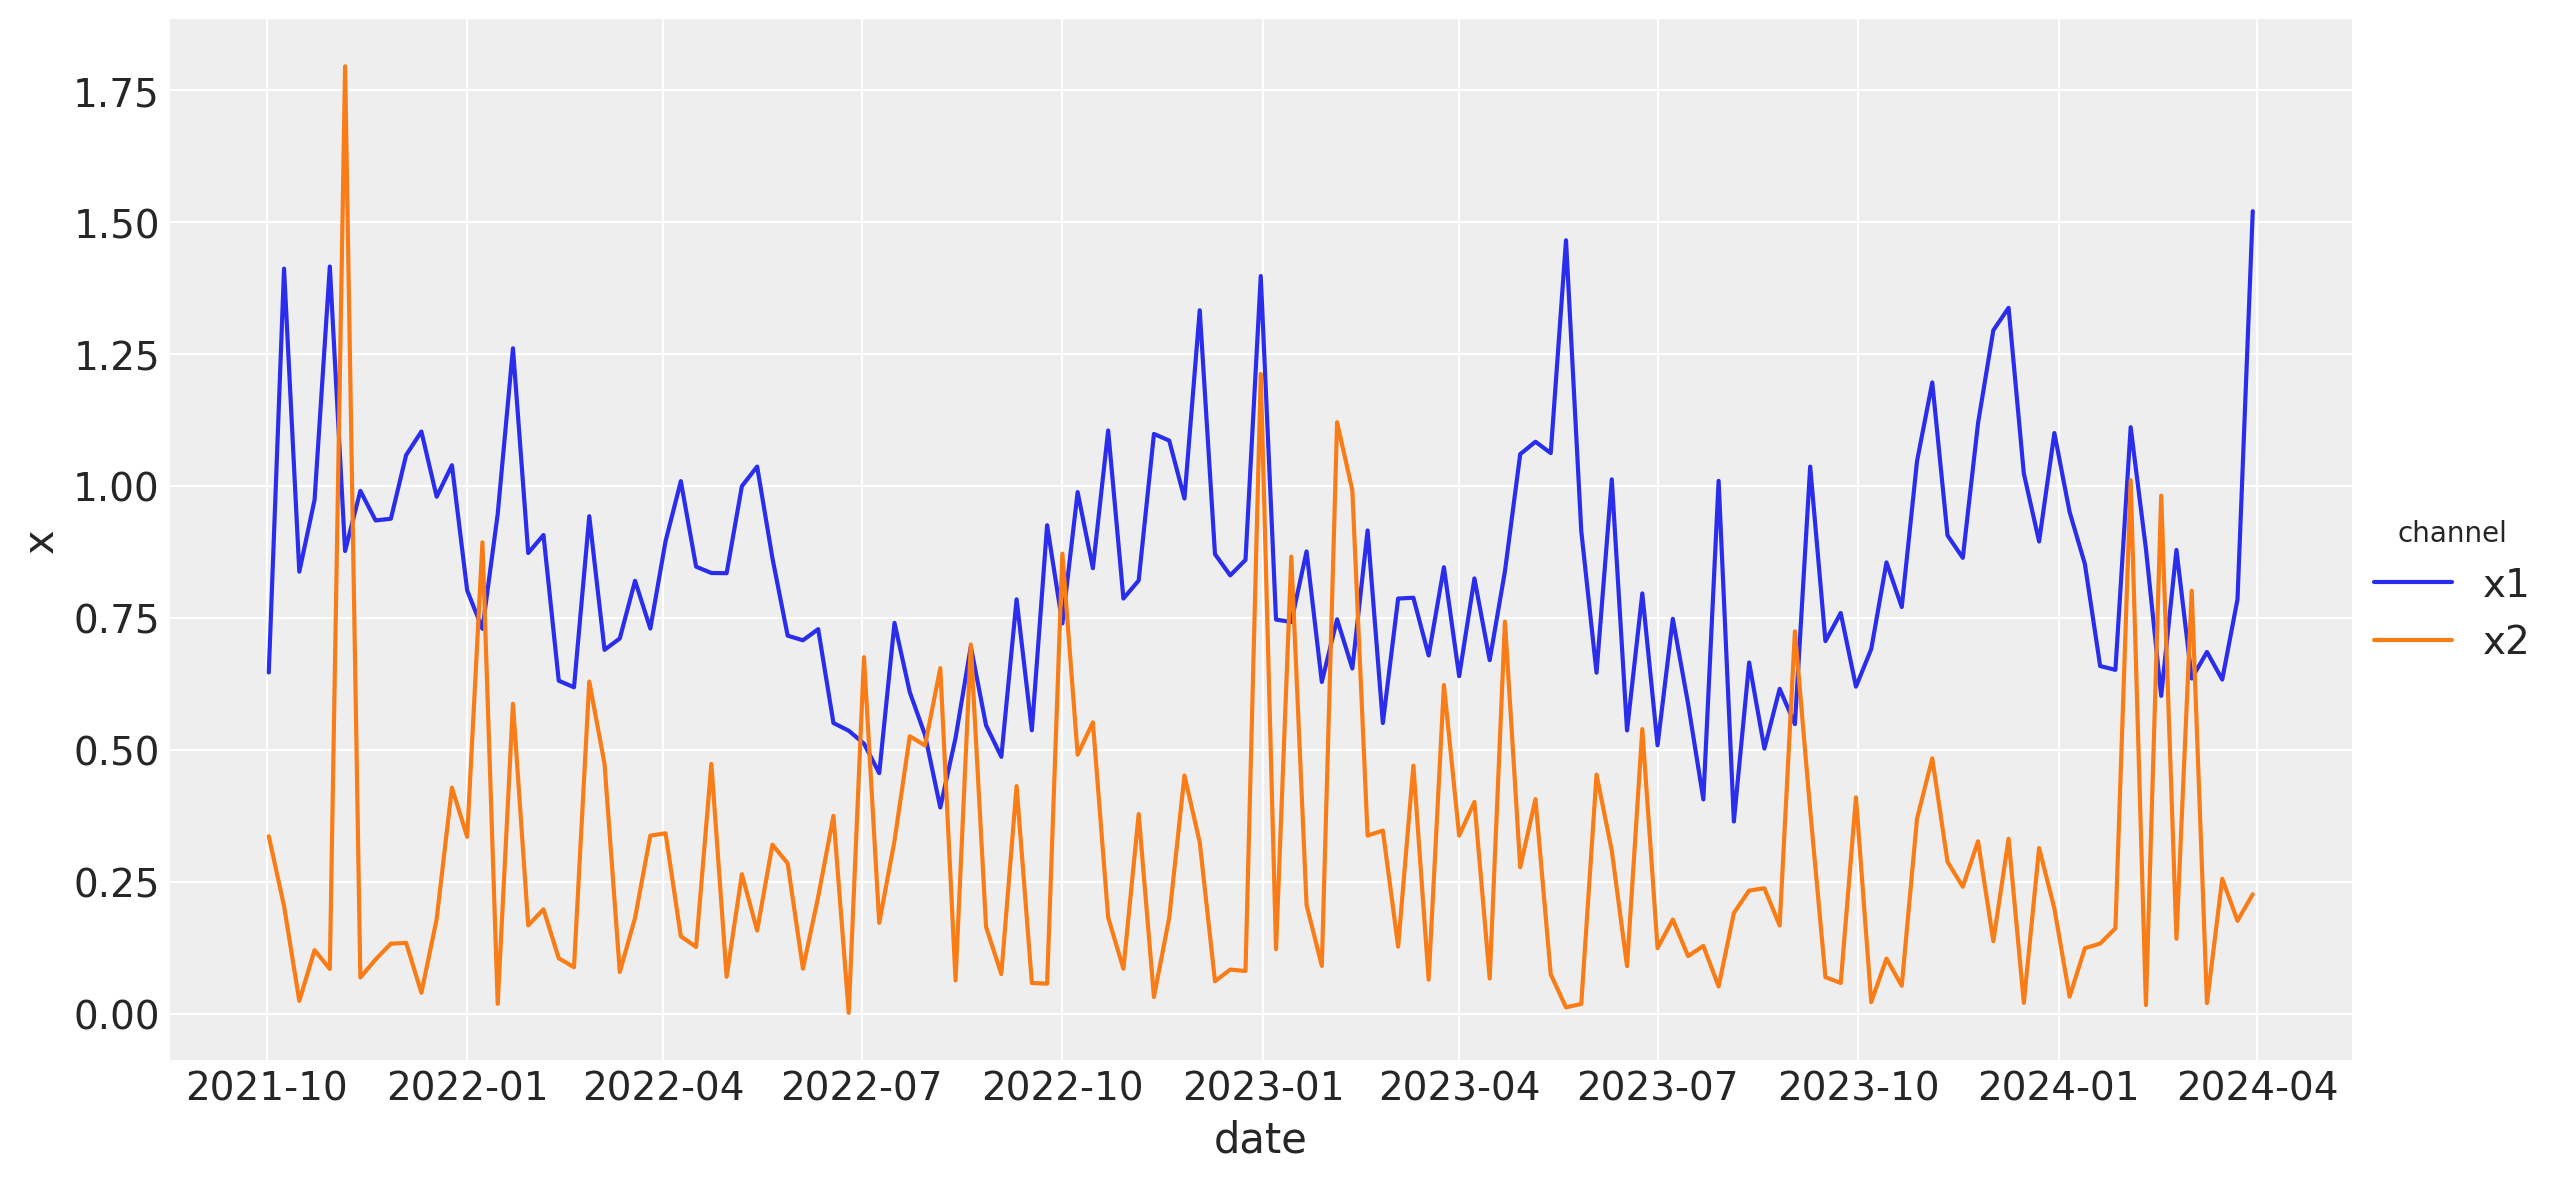

In [5]:
g = model_df.melt(
    id_vars=["date"], value_vars=["x1", "x2"], var_name="channel", value_name="x"
).pipe(
    (sns.relplot, "data"),
    kind="line",
    x="date",
    y="x",
    hue="channel",
    height=6,
    aspect=2,
);

## Baseline Model

In [6]:
cost_share = model_df[["x1", "x2"]].sum() / model_df[["x1", "x2"]].sum().sum()

In [7]:
model_config = {
    "intercept": Prior("Normal", mu=200, sigma=20),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
    "gamma_fourier": Prior("Normal", mu=0, sigma=2, dims="fourier_mode"),
    "intercept_tvp_config": HSGPKwargs(
        m=50, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None
    ),
    "adstock_alpha": Prior("Beta", alpha=2, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=2, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=cost_share.to_numpy(), dims="channel"),
}

In [8]:
%%time

mmm = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    time_varying_intercept=True,
    time_varying_media=False,
    yearly_seasonality=5,
    model_config=model_config,
)

y = model_df["y"]
X = model_df.drop(columns=["y"])

fit_kwargs = {"chains": 4, "nuts_sampler": "numpyro", "random_seed": rng}

mmm.fit(X, y, **fit_kwargs)
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True, random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


Output()

CPU times: user 27.7 s, sys: 4.86 s, total: 32.6 s
Wall time: 14.8 s


<xarray.Dataset> Size: 4MB
Dimensions:  (date: 131, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2021-10-02 2021-10-09 ... 2024-03-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 4MB 210.8 193.2 212.8 ... 541.8 539.4 555.0
Attributes:
    created_at:                 2024-08-07T08:17:07.653917+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.15.1

In [9]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

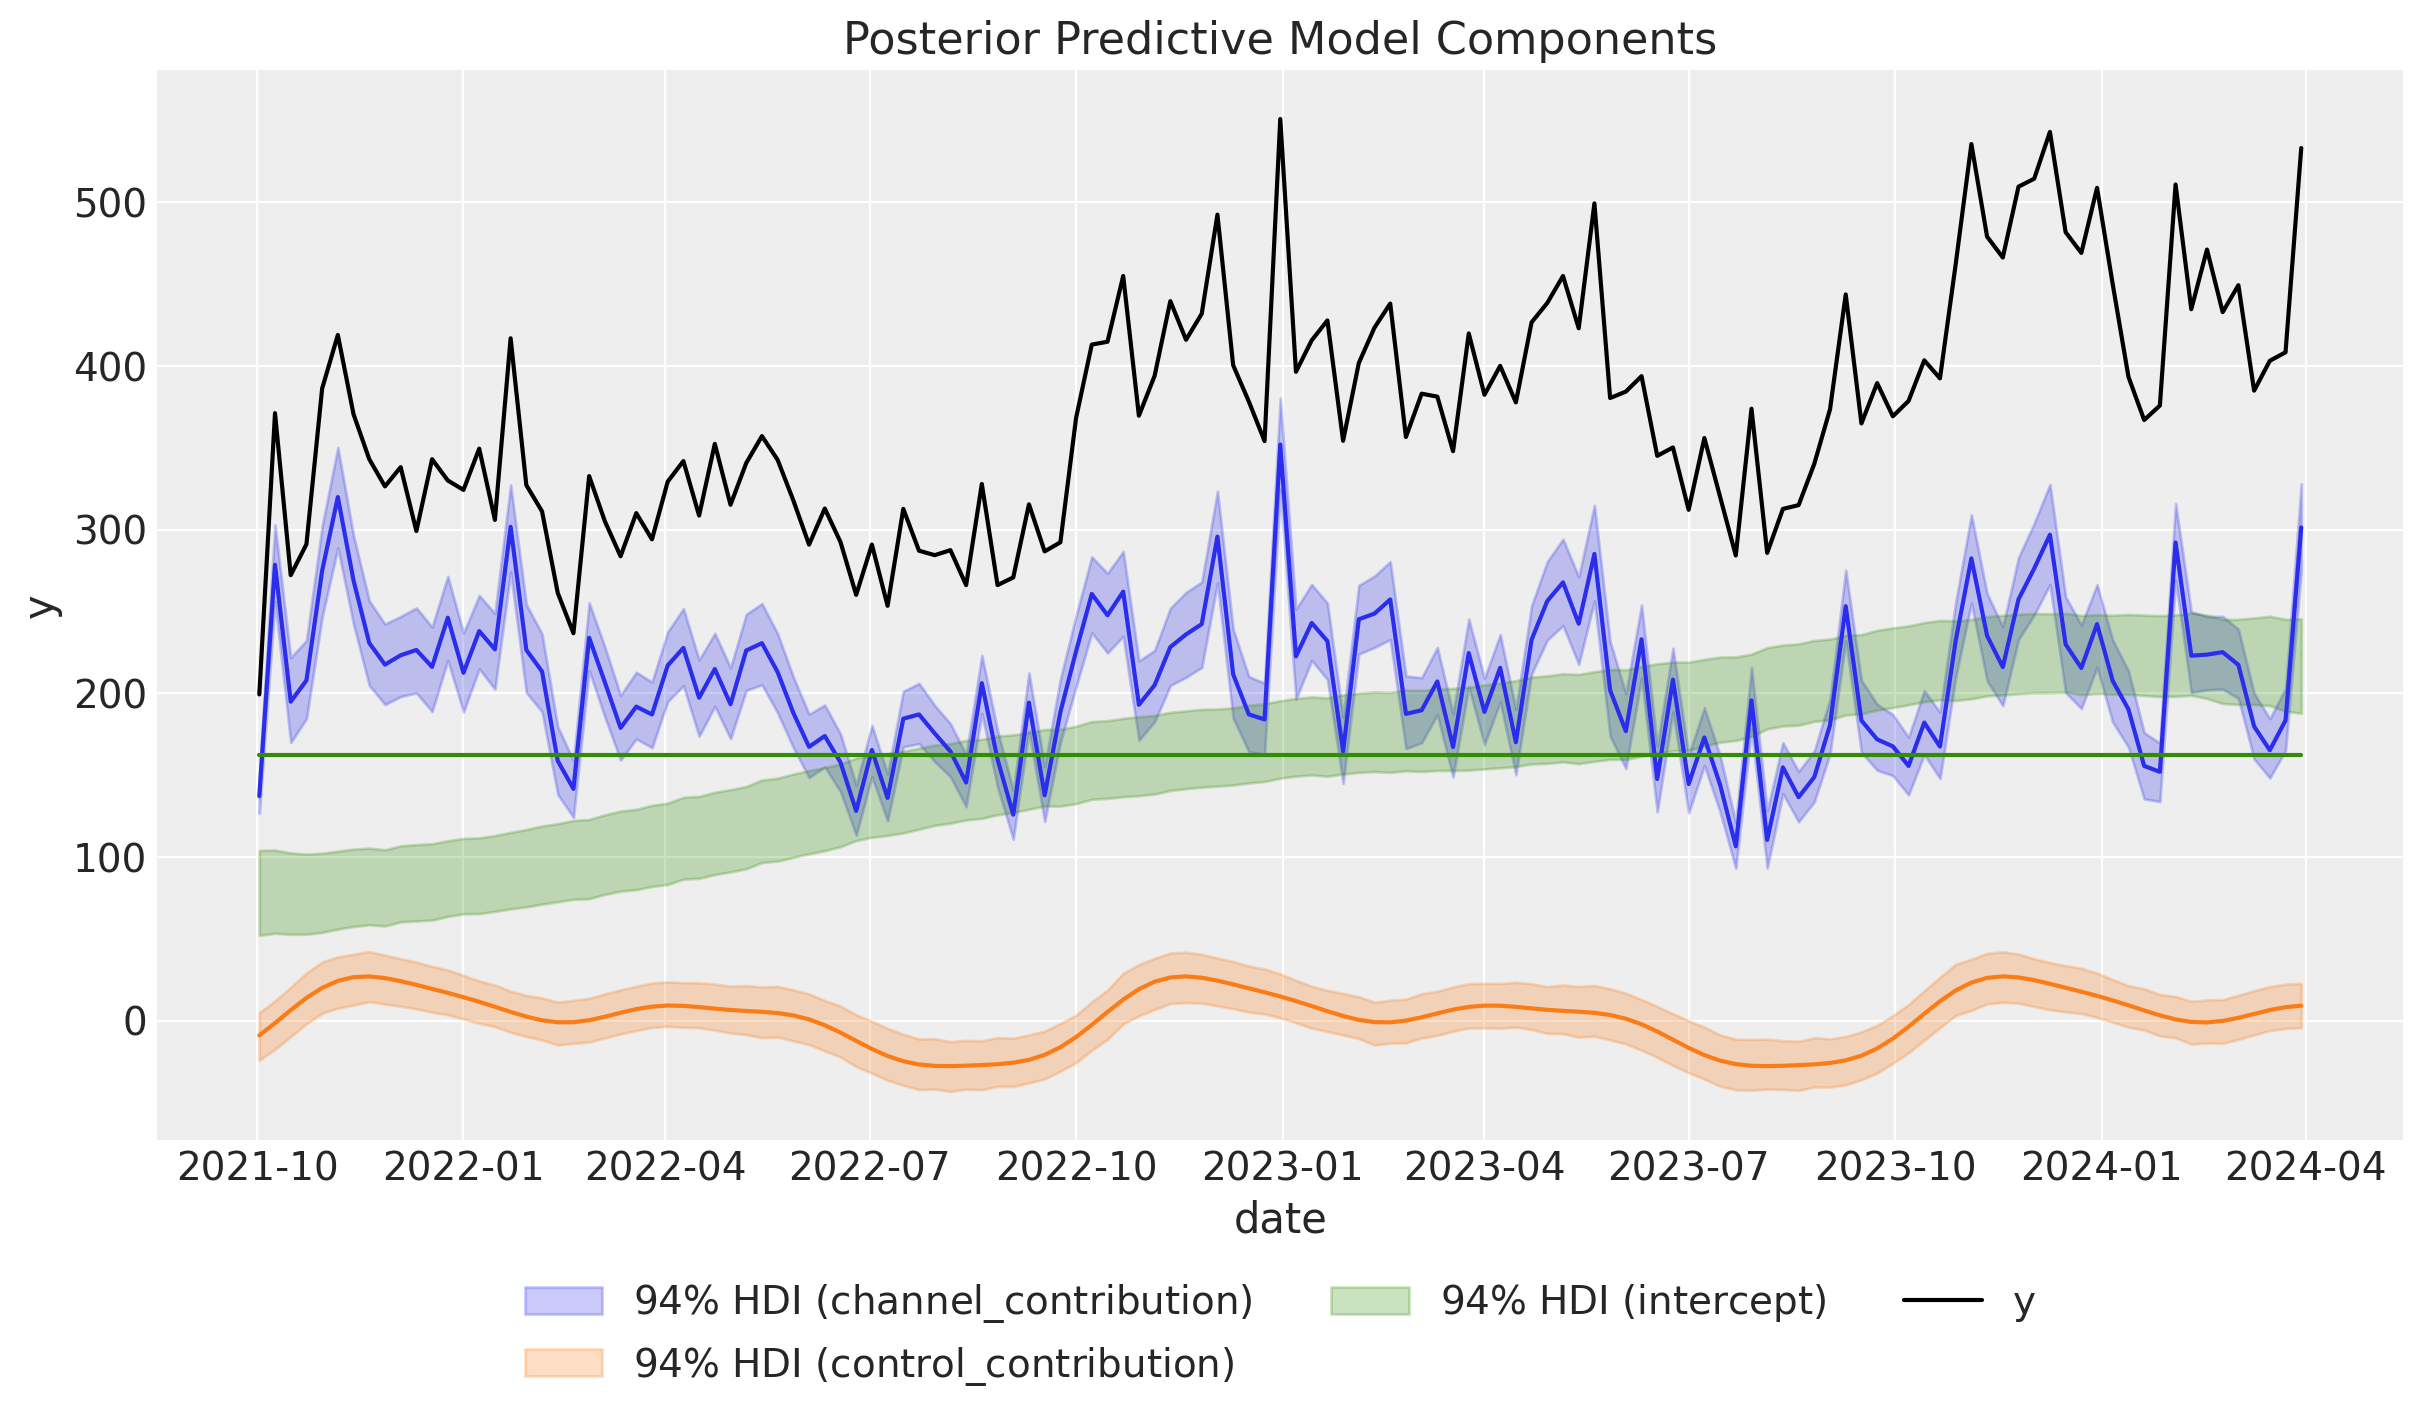

In [10]:
mmm.plot_components_contributions(original_scale=True);

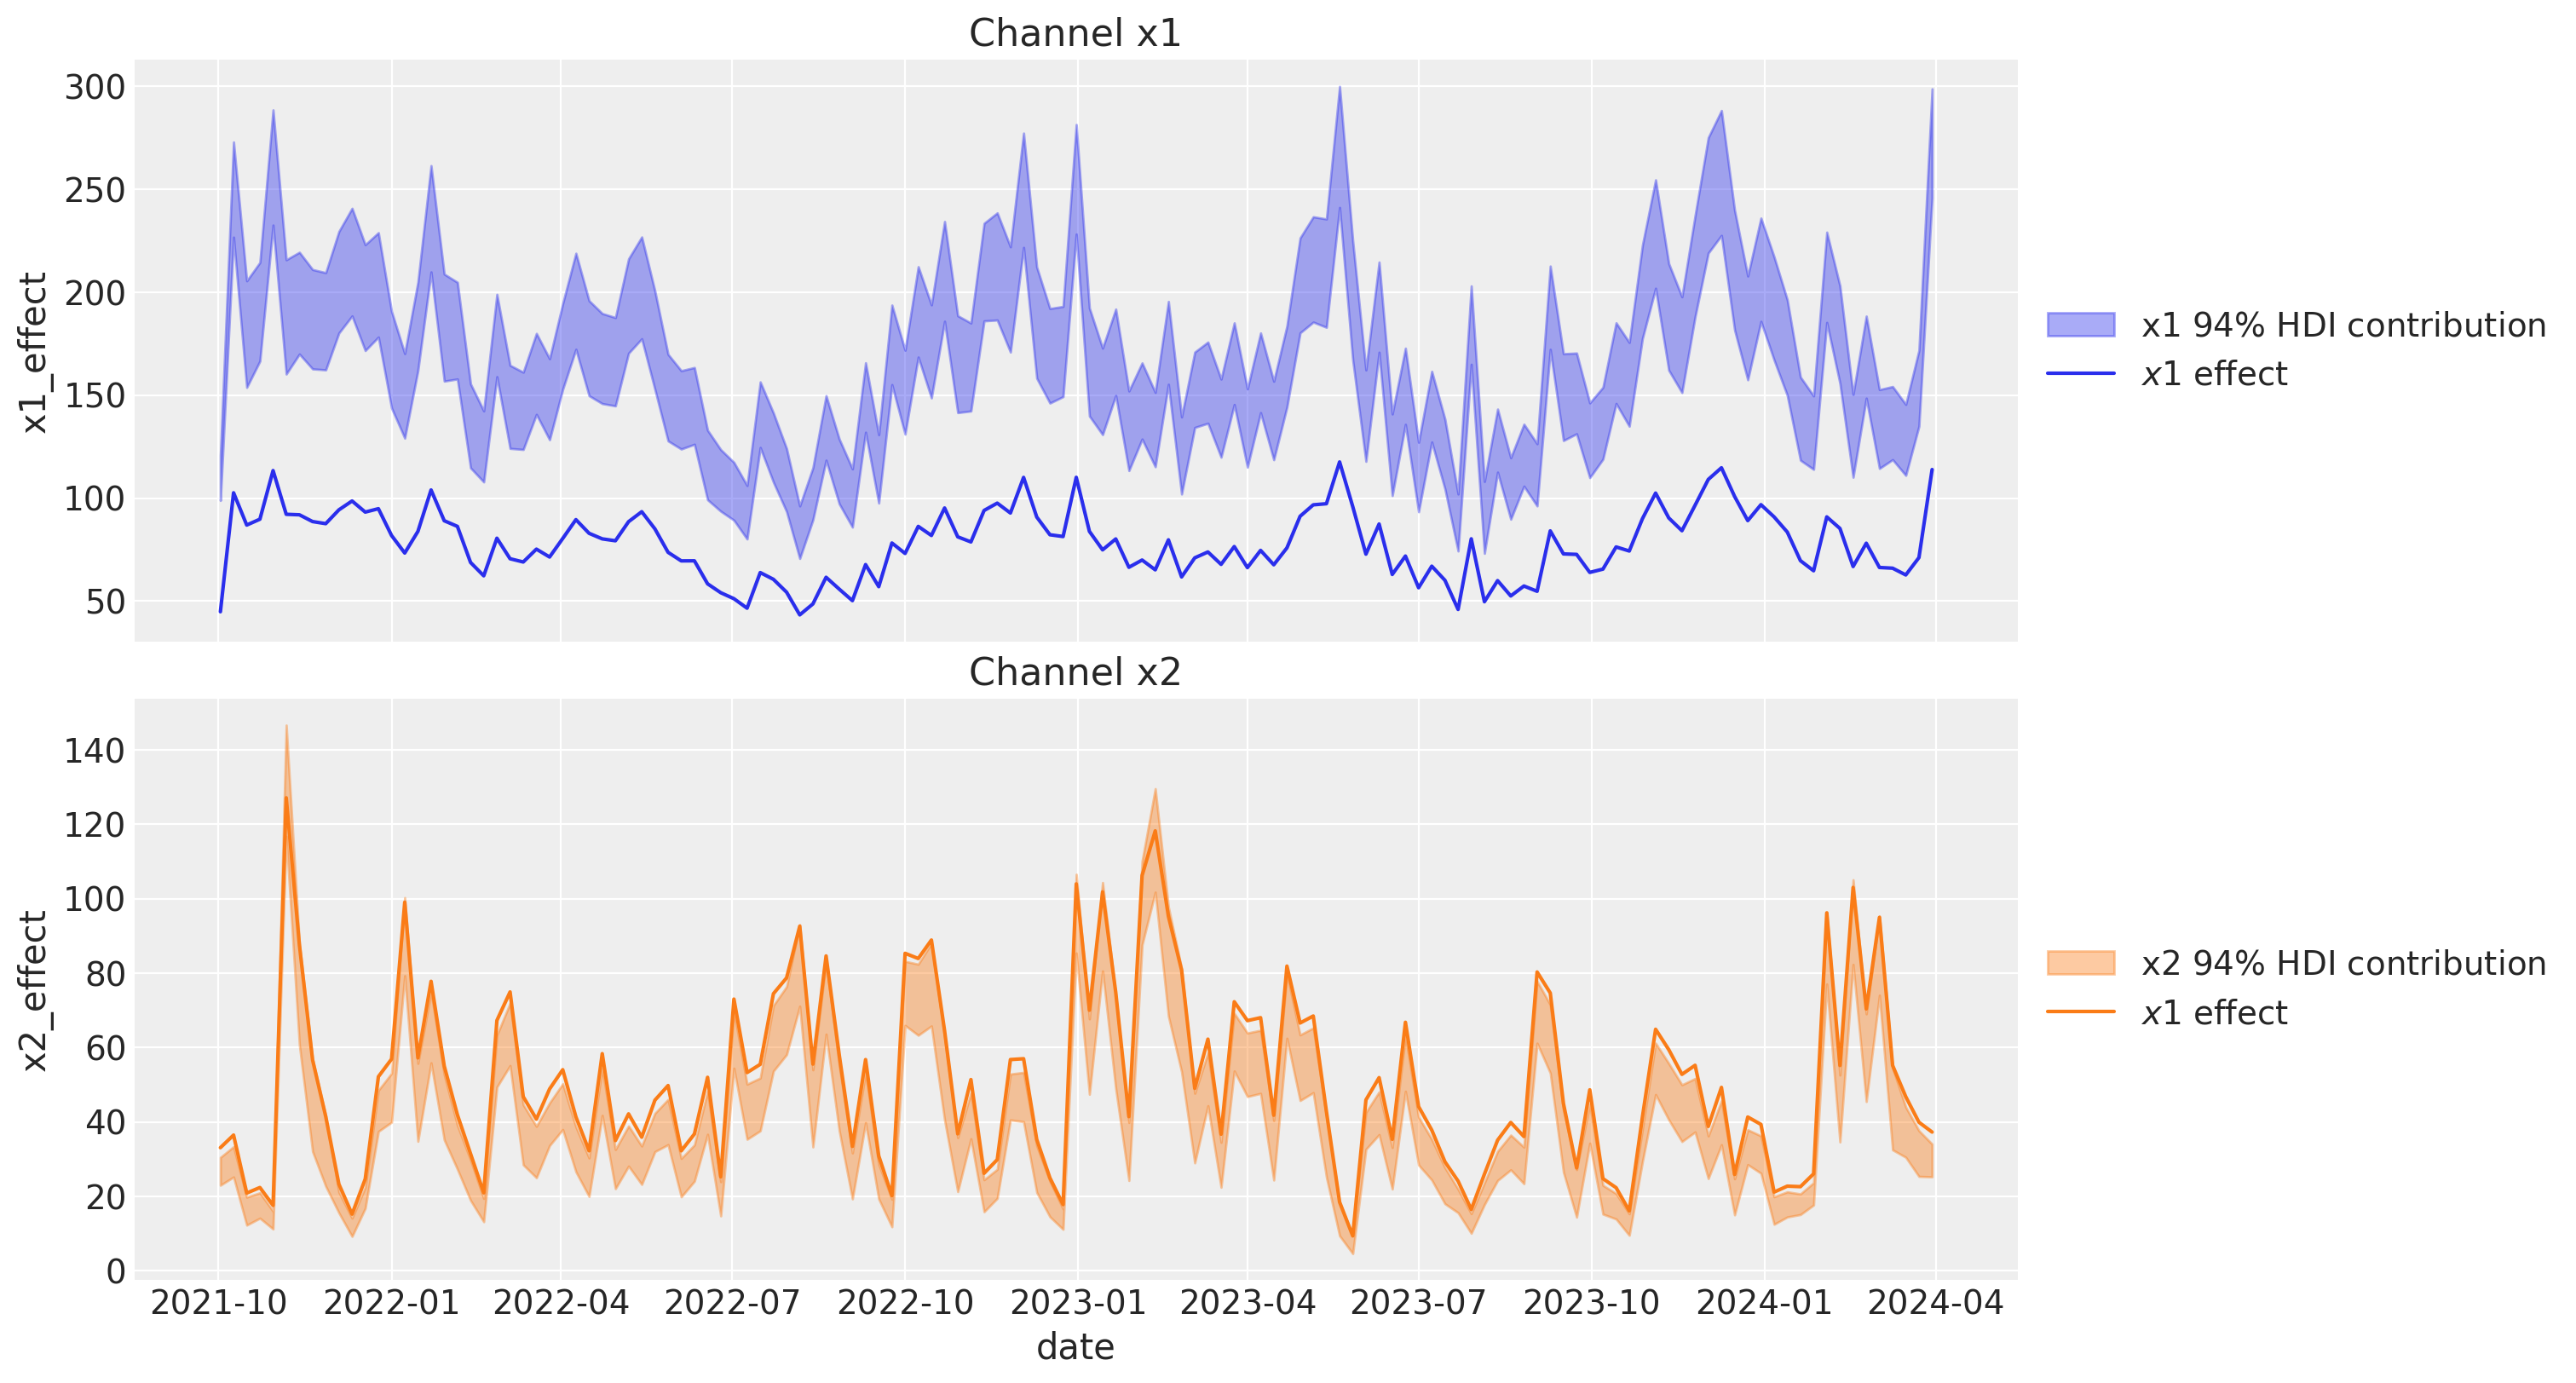

In [11]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=r"$x1$ effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

## Lift Test Model

In [12]:
model_config = {
    "intercept": Prior("Normal", mu=200, sigma=20),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
    "gamma_fourier": Prior("Normal", mu=0, sigma=2, dims="fourier_mode"),
    "intercept_tvp_config": HSGPKwargs(
        m=50, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None
    ),
    "adstock_alpha": Prior("Beta", alpha=2, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=2, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=1.5, dims="channel"),
}

mmm_lift = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    time_varying_intercept=True,
    time_varying_media=False,
    yearly_seasonality=5,
    model_config=model_config,
)

mmm_lift.build_model(X, y)

In [13]:
df_lift_test = pd.DataFrame(
    data={
        "channel": ["x1", "x2", "x1", "x2"],
        "x": [0.25, 0.1, 0.8, 0.25],
        "delta_x": [0.25, 0.1, 0.8, 0.25],
        "delta_y": [90 * 0.25, 175 * 0.1, 90 * 0.8, 175 * 0.25],
        "sigma": [3, 3, 3, 3],
    }
)

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,x1,0.25,0.25,22.50,3
1,x2,0.10,0.10,17.50,3
2,x1,0.80,0.80,72.00,3
3,x2,0.25,0.25,43.75,3


In [14]:
mmm_lift.add_lift_test_measurements(df_lift_test=df_lift_test)

In [15]:
mmm_lift.fit(X, y, **fit_kwargs)
# mmm.sample_posterior_predictive(X, extend_idata=True, combined=True, random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [16]:
# Number of diverging samples
mmm_lift.idata["sample_stats"]["diverging"].sum().item()

5

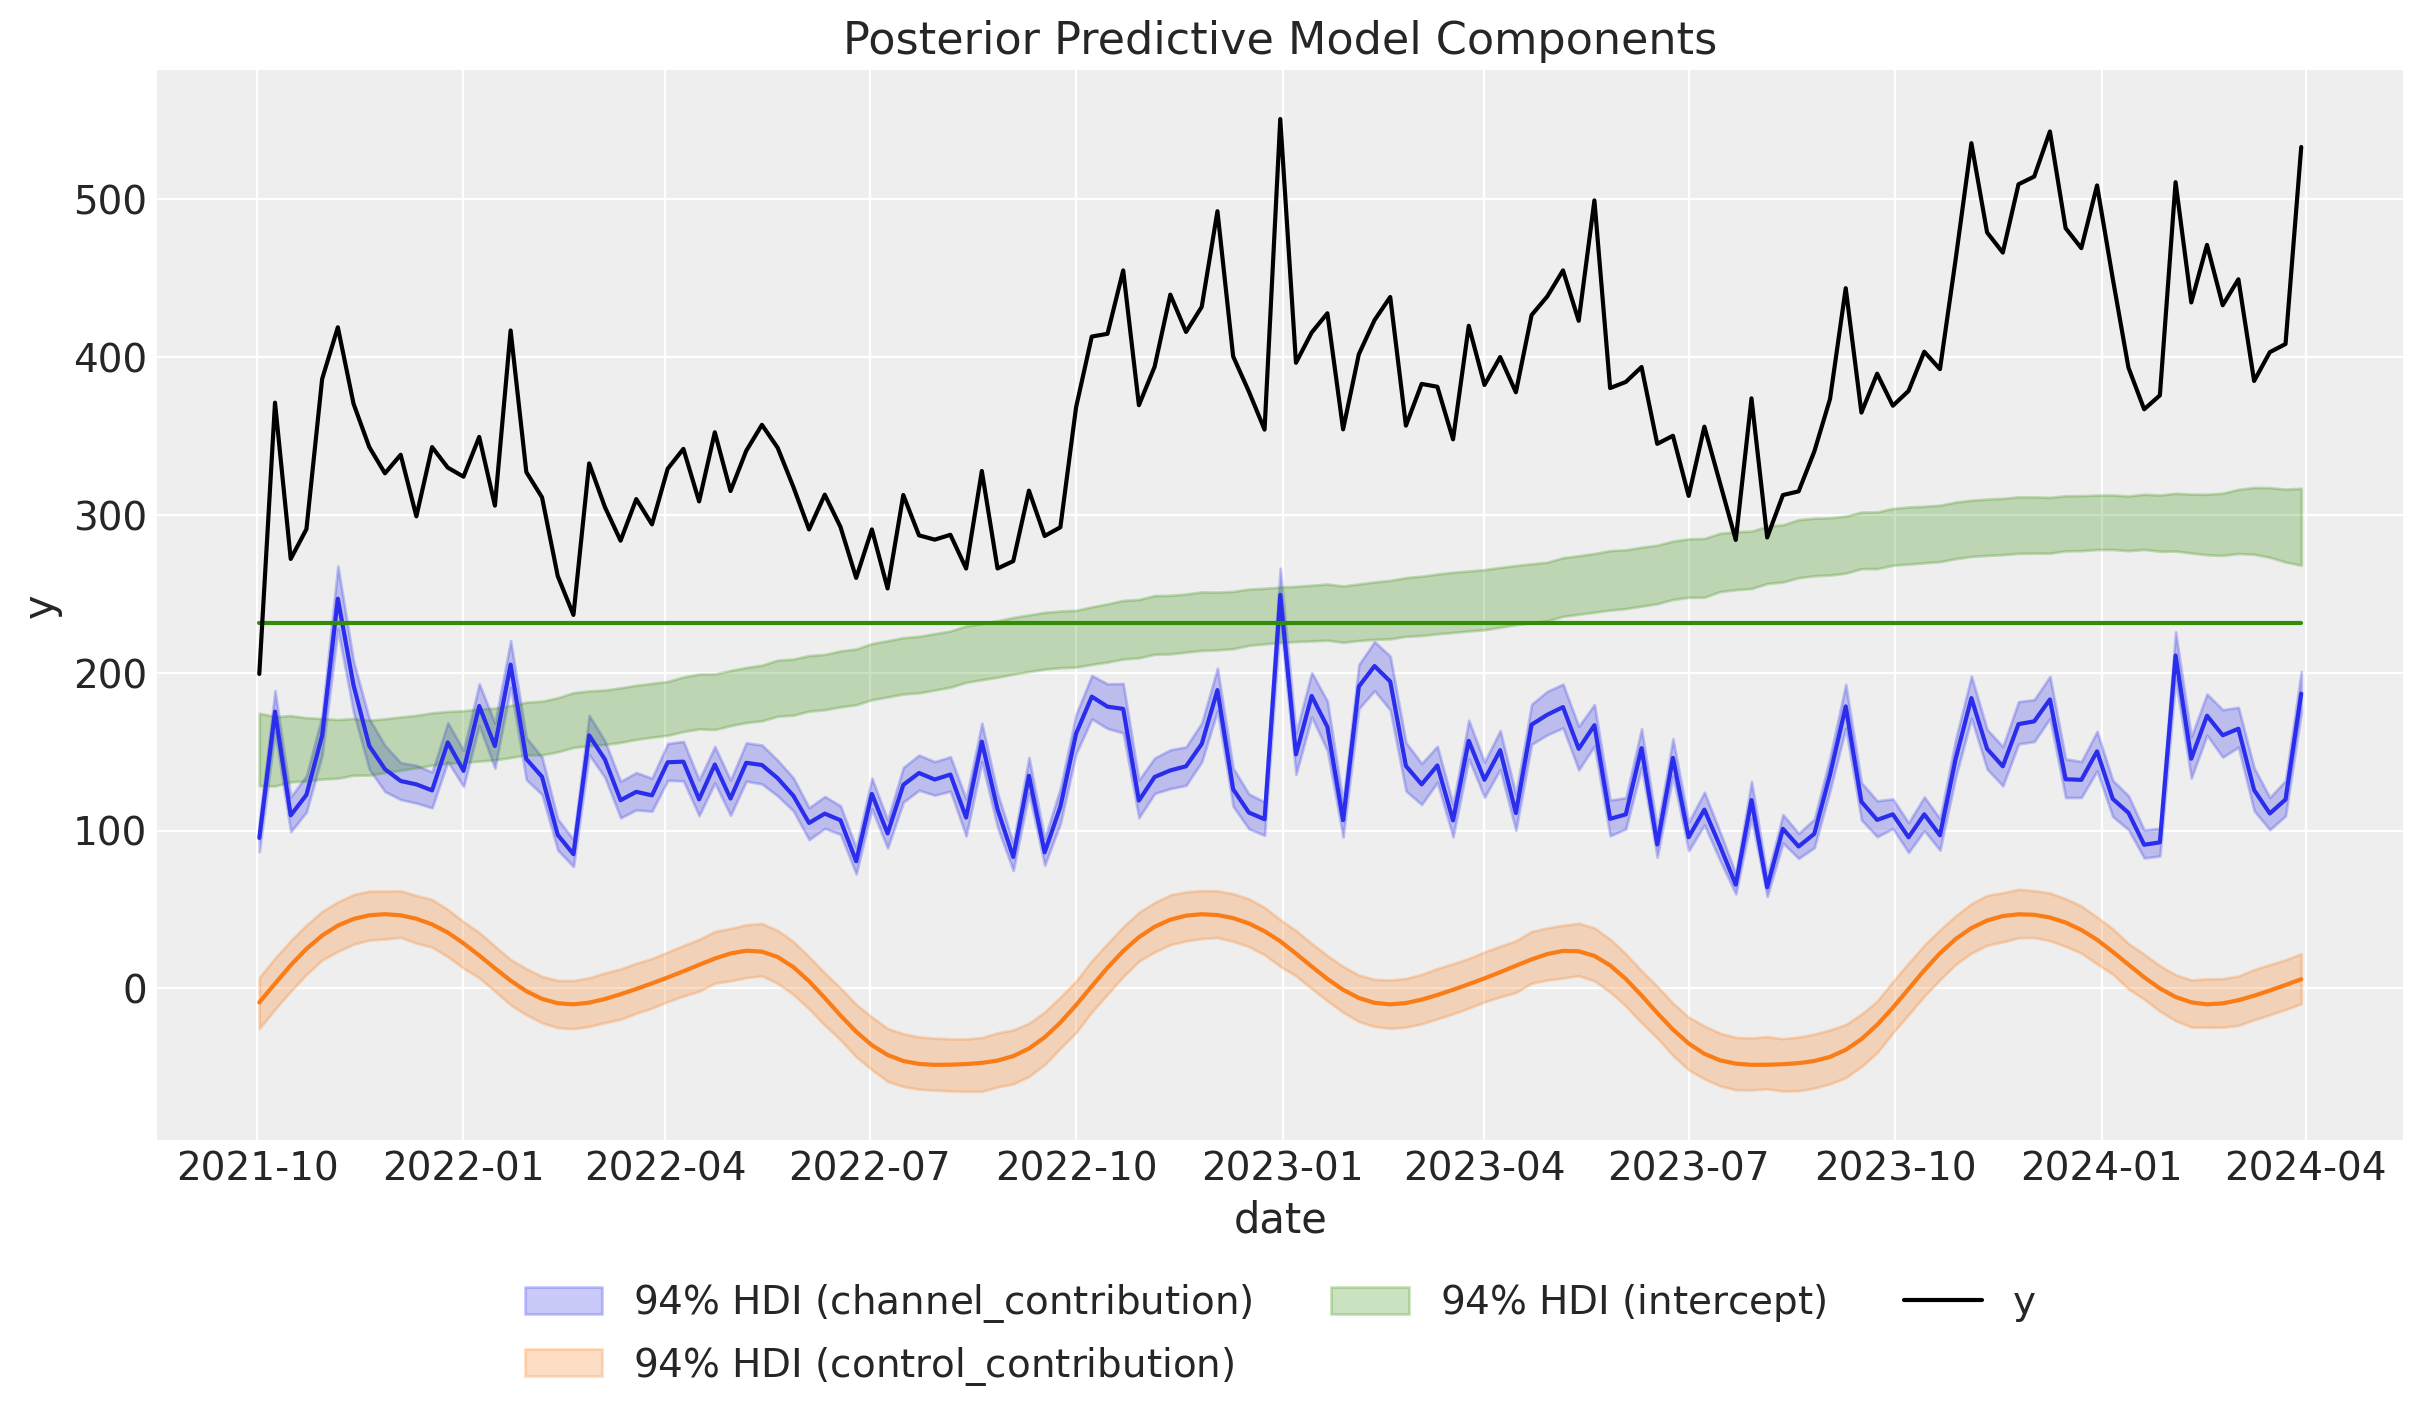

In [17]:
mmm_lift.plot_components_contributions(original_scale=True);

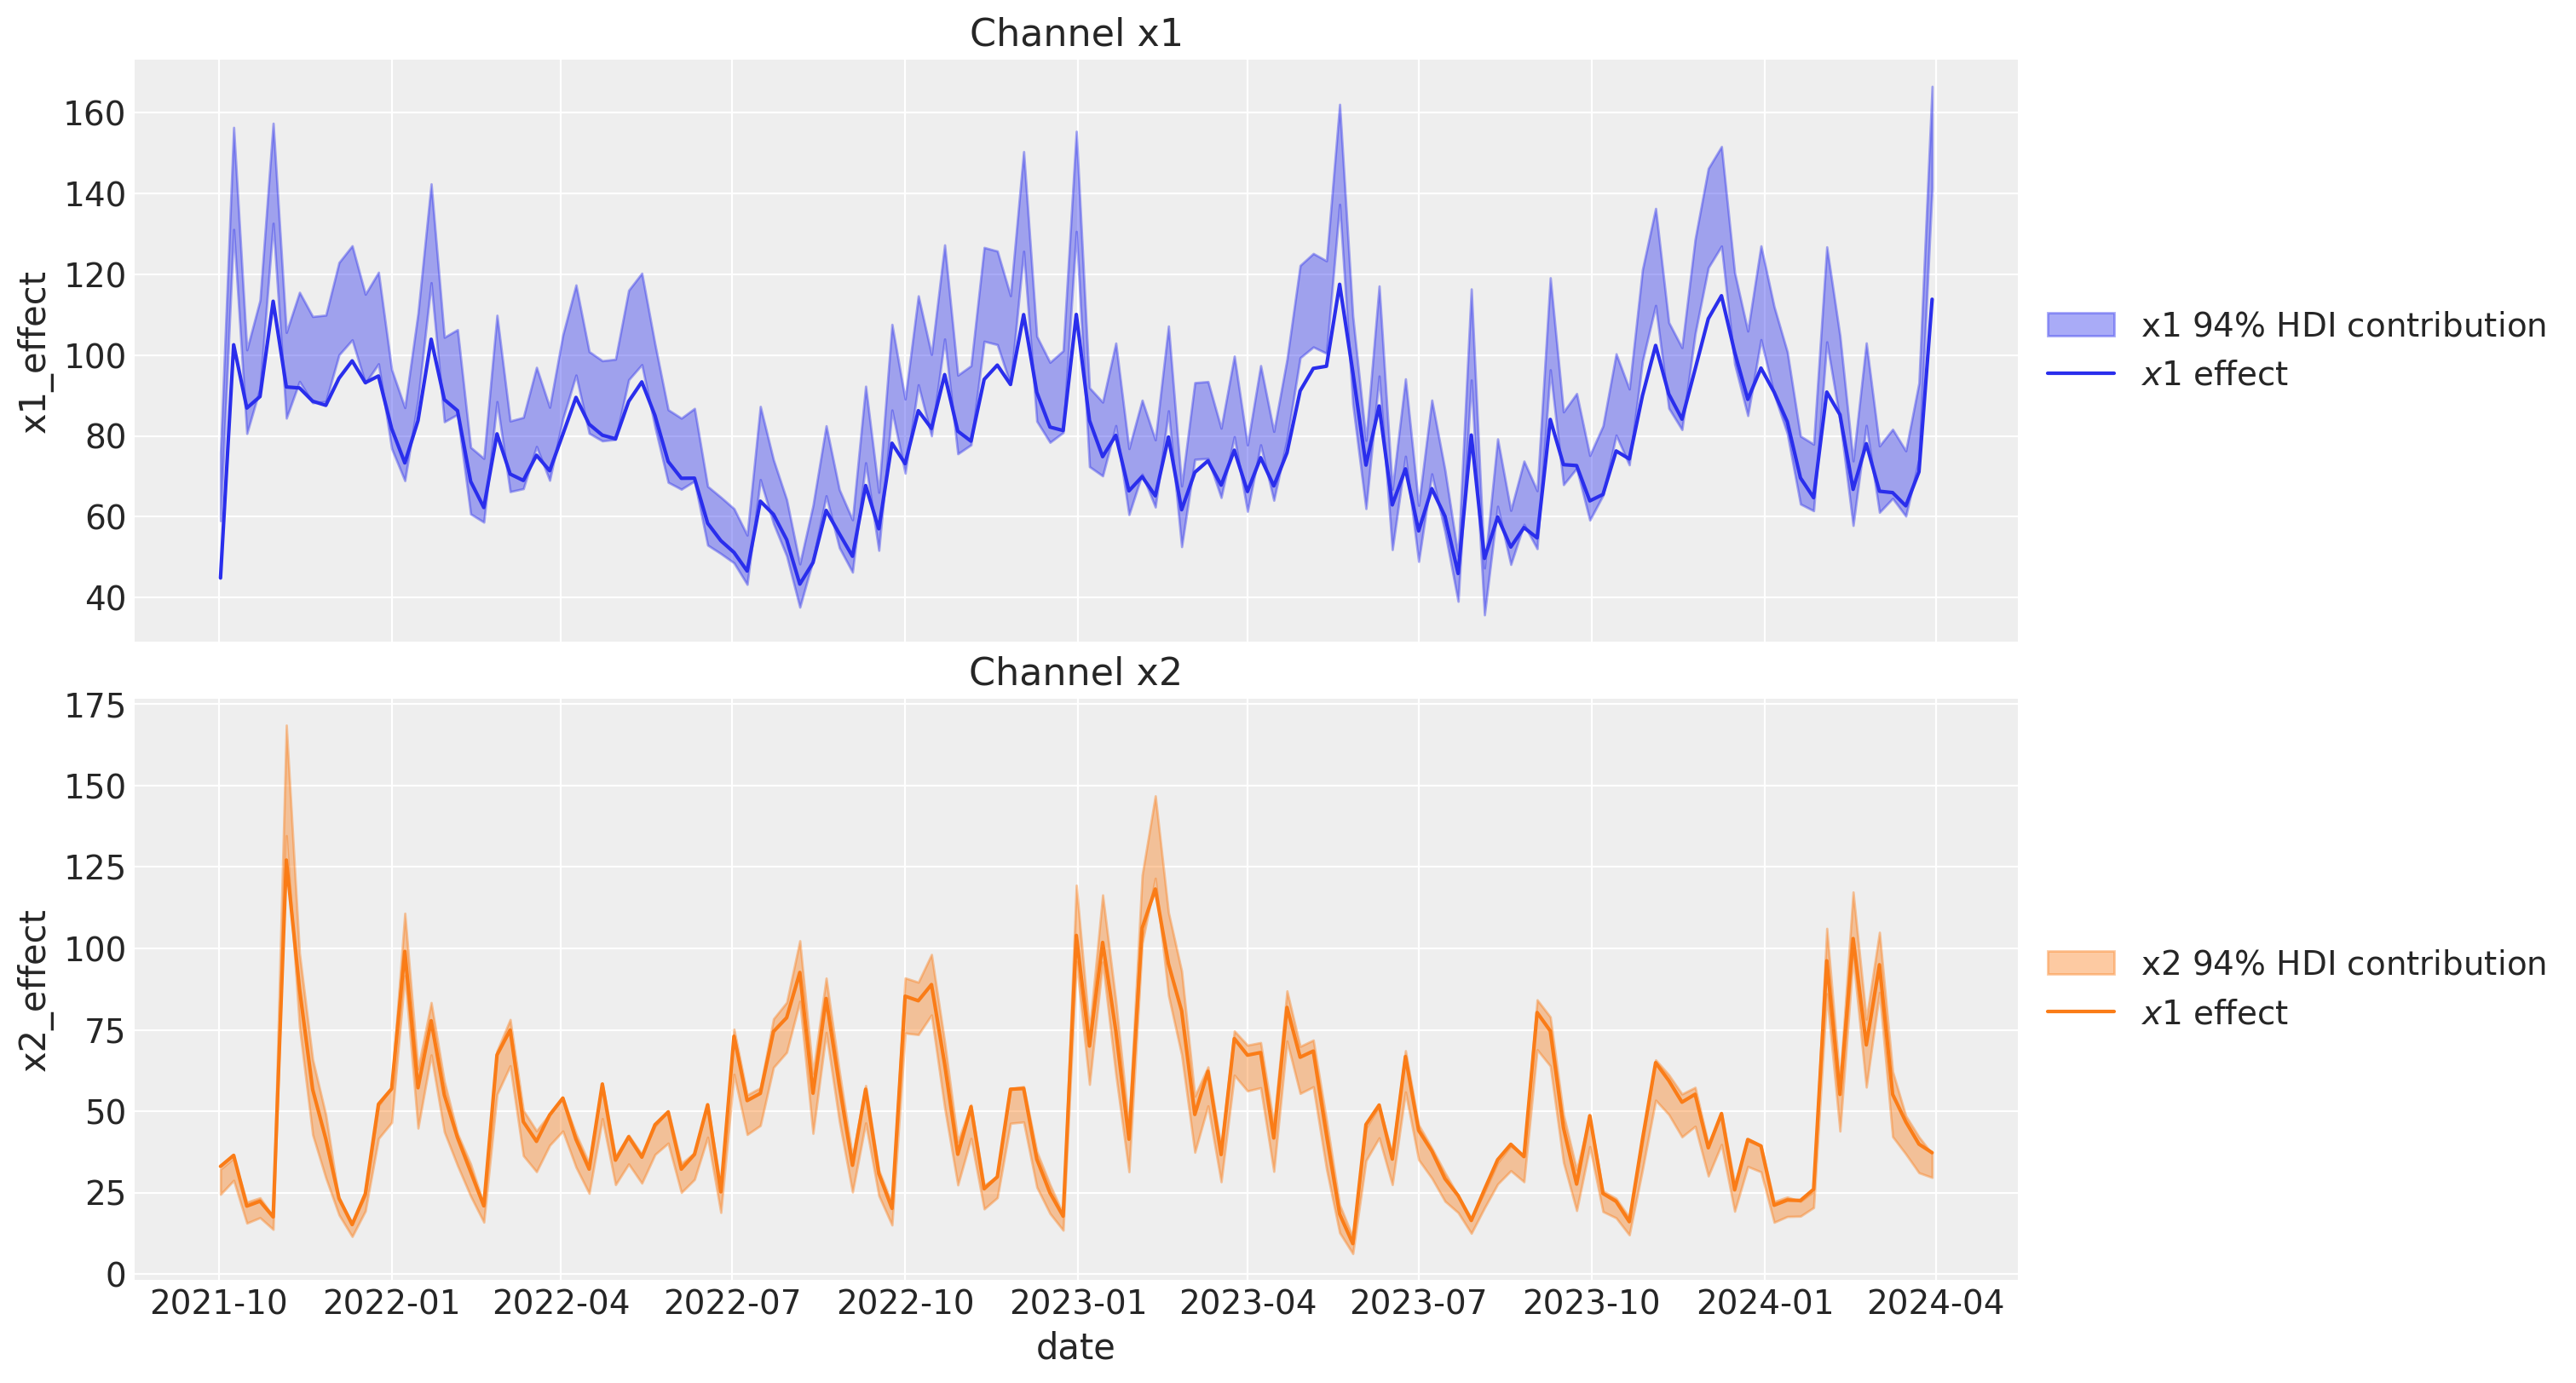

In [18]:
channels_contribution_original_scale = (
    mmm_lift.compute_channel_contribution_original_scale()
)
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=r"$x1$ effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")